<center/>

# Ridership of Toronto's Bike Share Program and Influence of Surrounding Venues

##### April 8, 2019 - Janice Tang


In [79]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

#### Bike Share in Toronto

Toronto is the biggest city in Canada with a population of 2.7M in 2016 [1], and it is projected to grow to 3.9M in 2041 [2]. To support such a large population, we not only need the infrastructure but also the transportation to move the population. Currently, bike share is underutilized as a public transportation option. In this project I will be looking at the usage of Toronto’s bike share program and how they correlate to the venues within the area. 

I am not a frequent user of the bike share program, but I do personally see the benefits of bike sharing services. One being that I might need a fast ride to somewhere close without the burden of thinking about where to park my car or bike. I suspect that other users will also perform some kind of cost-benefit analysis that considers the distance traveled and the occasion before deciding to use a bike share. Also, you most likely will not use it for off-road biking or biking through the park. Thus, there may be some correlation between bike share usage and the surrounding venues. 

This brings us to believe that the target market for bike share programs is much different from the normal commuter or urban biker. I have not found any research on this segment group, but analysis of bike share usage will shed some light on how to increase efficiencies of docking stations and generate insights on how to better market the program. 

When learning about bike share users, we will first consider segmenting ridership and map it alongside clusters of venue density. This will help us determine if certain types of venues will attract higher ridership.

#### Data Requirements

- Postal regions of Toronto were scrapped from the Wikipedia page [3], with the BeautifulSoup4 package [4]. Using the Geocoder package, this data was merged with latitude and longitude coordinates.


In [1]:
# Import packages
from bs4 import BeautifulSoup
import string
import numpy as np
import pandas as pd
import requests

# Use BeautifulSoup Package to scrap Wikipedia Page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source, 'lxml')
table_text = soup.find('table', class_="wikitable sortable")

table_text = str(table_text)
text_clean = table_text.replace('</tr>','')
text_clean = text_clean.replace('</td>','')
text_clean = text_clean.replace('\n','')
table_list = text_clean.split('<tr>')
table_list = table_list[1:]
header_text = table_list[0]
table_list = table_list[1:]
table_list2 = []
for i in table_list:
    i = i.replace('<a href="/wiki/','')
    i = i.replace('</a>','')
    row = i.split('<td>')
    row[3] = row[3][(row[3].find(">"))+1:]
    row[2] = row[2][(row[2].find(">"))+1:]
    if row[3] == 'Not assigned': 
        row[3] = row[2]
    row[3] = row[3]
    if row[2] != 'Not assigned': 
        table_list2.append(row[1:])

table_list3 = []
table_unique = []
for i in table_list2:
    if i[0] not in table_unique: 
        code = i[0]
        area = i[1]
        neigh = i[2]
        for j in table_list2:
            if j[0] == code and j[2] not in neigh:
                neigh = neigh + ', ' + j[2]
        table_list3.append([code, area, neigh])
        table_unique.append(code)

# Transform array into pandas dataframe
Toronto_postaldf = pd.DataFrame(table_list3)
headers = ["PostalCode","Borough", "Neighborhood"]
Toronto_postaldf.columns = headers

# Load Latitute and Longitude data from personal directory
url = "/Users/jtang/Downloads/Geospatial_Coordinates.csv"
latlong_postaldf = pd.read_csv(url) 

# Merge Latitute and Longitude data with Toronto Postal Code List
postaldf = Toronto_postaldf.set_index("PostalCode").join(latlong_postaldf.set_index("Postal Code"))
postaldf.reset_index(inplace=True)

# Filter to Nieghborhoods in Toronto only
postaldf = postaldf[(postaldf.Borough == 'Downtown Toronto') |
       (postaldf.Borough == 'Central Toronto') |
       (postaldf.Borough == 'West Toronto') |
       (postaldf.Borough == 'East Toronto')]
postaldf.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


- The Foursqaure API was used to get surrounding venues of a neighborhood and frequencies of types of venues were counted and merged with the list postal regions in Toronto [5].

In [2]:
# getNearbyVenues Function
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)   
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [3]:
# return_most_common_venues Function 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [4]:
# Import Packages
from geopy.geocoders import Nominatim

# Get the Latitute and Longitude Coordinates for Toronto
city = 'Toronto, ON'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude

# Four Sqaure Credentials and use getNearbyVenues to get data
CLIENT_ID = 'OOJ3SLOPFNOJF1UKBAHPXBZ2HFNWG45WQBI2SL2OA543MR42' # your Foursquare ID
CLIENT_SECRET = '4ROLWVSLGPOBT0KHZICUEGUAXUR5WWZLUW3UT0MAHETQILT4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
toronto_venues = getNearbyVenues(names=postaldf['Neighborhood'],
                                   latitudes=postaldf['Latitude'],
                                   longitudes=postaldf['Longitude'])

# Convert Venue Category data into dummy variables and merge with Neighborhood data to get a count of how many venues are in the neightborhood
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()

# Merge with postal code table to get a groupby table by 'PostalCode'
postal_codes = postaldf[['PostalCode', 'Neighborhood']]
toronto_grouped = toronto_grouped.set_index('Neighborhood').join(postal_codes.set_index('Neighborhood'))
toronto_grouped.reset_index(inplace=True)
toronto_grouped = toronto_grouped.drop('Neighborhood', axis=1)
toronto_grouped = toronto_grouped.groupby('PostalCode').sum().reset_index()

In [6]:
# Create a new dataframe where it list the top 10 most common venues from most to 10th most common venues within a neightborhood
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['PostalCode']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Coffee Shop,Health Food Store,Trail,Pub,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop
1,M4K,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Furniture / Home Store,Japanese Restaurant,Indian Restaurant,Caribbean Restaurant,Bakery
2,M4L,Sandwich Place,Food & Drink Shop,Steakhouse,Sushi Restaurant,Fish & Chips Shop,Ice Cream Shop,Pub,Fast Food Restaurant,Burrito Place,Movie Theater
3,M4M,Café,Coffee Shop,Italian Restaurant,Bakery,Gastropub,American Restaurant,Bar,Sandwich Place,Stationery Store,Bank
4,M4N,Bus Line,Park,Swim School,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


- 2017 ridership data [6] and station location in latitude and longitude coordinates [7] were available on the City of Toronto Website.

In [78]:
# Import packages
import json

# Read in Bike Station location in Latitude and Longitude coordinates.
bike_json = "/Users/jtang/Downloads/station_information.json"
with open(bike_json) as json_data:
    d = json.load(json_data)
data = d['data']
data = data['stations']
stations = json.dumps(data)
stations_name = pd.read_json(stations)

# Because the PostalCode column is mostly blank, I will need to match Toronto Postal data with the 
# Bike station by closet distance calculated with Latitude and Longitude coordinates.
stations_name = np.array(stations_name[['name','station_id','lat', 'lon',]])
latlong_postal = np.array(postaldf[['PostalCode', 'Latitude', 'Longitude']])
station_data = []
for i in range(0,len(stations_name)):
    row = []
    min_distance = 100000000
    postal = ''
    for j in range(0,len(latlong_postal)):
        distance = np.square((stations_name[i][2]-latlong_postal[j][1])**2 + (stations_name[i][3]-latlong_postal[j][2])**2)
        if distance < min_distance:
            min_distance = distance
            postal = latlong_postal[j][0]
    row.append(stations_name[i][0])
    row.append(stations_name[i][1])
    row.append(stations_name[i][2])
    row.append(stations_name[i][3])
    row.append(postal)
    station_data.append(row)
station_data = pd.DataFrame(station_data)
header = ['name', 'station_id', 'Latitude', 'Longitude', 'PostalCode']
station_data.columns = header

#station_data = pd.DataFrame(station_data['PostalCode'].value_counts())
#station_data.shape

In [8]:
# Load all the ridership data
Q1_CSV = "/Users/jtang/Downloads/2017 Data/Bikeshare Ridership (2017 Q1).csv"
Q1_RDS = pd.read_csv(Q1_CSV) 
Q2_CSV = "/Users/jtang/Downloads/2017 Data/Bikeshare Ridership (2017 Q2).csv"
Q2_RDS = pd.read_csv(Q2_CSV) 
Q3_CSV = "/Users/jtang/Downloads/2017 Data/Bikeshare Ridership (2017 Q3).csv"
Q3_RDS = pd.read_csv(Q3_CSV) 
Q4_CSV = "/Users/jtang/Downloads/2017 Data/Bikeshare Ridership (2017 Q4).csv"
Q4_RDS = pd.read_csv(Q4_CSV) 

# Looks there is no station id in Q3 and Q4 data so I would need to merge the station id by matching station name
# Since I am merging the station id to Q3 and Q4, might as well merge the postal code data.
station_id = station_data[['name', 'station_id','PostalCode']]
station_id2 = station_data[['name','PostalCode']]
Q2_RDS = Q2_RDS.set_index('from_station_name').join(station_id2.set_index('name'))
Q2_RDS.rename(columns={'PostalCode':'from_PostalCode'}, inplace=True)
Q2_RDS.reset_index(inplace=True)
Q2_RDS.rename(columns={'index':'from_station_name'}, inplace=True)
Q2_RDS = Q2_RDS.set_index('to_station_name').join(station_id2.set_index('name'))
Q2_RDS.rename(columns={'PostalCode':'to_PostalCode'}, inplace=True)
Q2_RDS.reset_index(inplace=True)
Q2_RDS.rename(columns={'index':'to_station_name'}, inplace=True)

Q1_RDS = Q1_RDS.set_index('from_station_name').join(station_id2.set_index('name'))
Q1_RDS.rename(columns={'PostalCode':'from_PostalCode'}, inplace=True)
Q1_RDS.reset_index(inplace=True)
Q1_RDS.rename(columns={'index':'from_station_name'}, inplace=True)
Q1_RDS = Q1_RDS.set_index('to_station_name').join(station_id2.set_index('name'))
Q1_RDS.rename(columns={'PostalCode':'to_PostalCode'}, inplace=True)
Q1_RDS.reset_index(inplace=True)
Q1_RDS.rename(columns={'index':'to_station_name'}, inplace=True)

Q3_RDS = Q3_RDS.set_index('from_station_name').join(station_id.set_index('name'))
Q3_RDS.rename(columns={'station_id':'from_station_id', 'PostalCode':'from_PostalCode'}, inplace=True)
Q3_RDS.reset_index(inplace=True)
Q3_RDS.rename(columns={'index':'from_station_name'}, inplace=True)
Q3_RDS = Q3_RDS.set_index('to_station_name').join(station_id.set_index('name'))
Q3_RDS.rename(columns={'station_id':'to_station_id', 'PostalCode':'to_PostalCode'}, inplace=True)
Q3_RDS.reset_index(inplace=True)
Q3_RDS.rename(columns={'index':'to_station_name'}, inplace=True)

Q4_RDS = Q4_RDS.set_index('from_station_name').join(station_id.set_index('name'))
Q4_RDS.rename(columns={'station_id':'from_station_id','PostalCode':'from_PostalCode'}, inplace=True)
Q4_RDS.reset_index(inplace=True)
Q4_RDS.rename(columns={'index':'from_station_name'}, inplace=True)
Q4_RDS = Q4_RDS.set_index('to_station_name').join(station_id.set_index('name'))
Q4_RDS.rename(columns={'station_id':'to_station_id', 'PostalCode':'to_PostalCode'}, inplace=True)
Q4_RDS.reset_index(inplace=True)
Q4_RDS.rename(columns={'index':'to_station_name'}, inplace=True)

Q1_RDS = Q1_RDS[['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name','from_PostalCode', 'to_station_id', 'to_station_name', 'to_PostalCode', 'user_type']]
Q2_RDS = Q2_RDS[['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name','from_PostalCode', 'to_station_id', 'to_station_name', 'to_PostalCode', 'user_type']]
Q3_RDS = Q3_RDS[['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name','from_PostalCode', 'to_station_id', 'to_station_name', 'to_PostalCode', 'user_type']]
Q4_RDS = Q4_RDS[['trip_id', 'trip_start_time', 'trip_stop_time', 'trip_duration_seconds', 'from_station_id', 'from_station_name','from_PostalCode', 'to_station_id', 'to_station_name', 'to_PostalCode', 'user_type']]

quarters = [Q1_RDS, Q2_RDS, Q3_RDS, Q4_RDS]
RDS_2017 = pd.concat(quarters)
RDS_2017.head()


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,from_PostalCode,to_station_id,to_station_name,to_PostalCode,user_type
0,733750,17/01/2017 13:53,17/01/2017 13:57,241,7071.0,161 Bleecker St (South of Wellesley),M4X,7071.0,161 Bleecker St (South of Wellesley),M4X,Member
1,758478,30/01/2017 20:01,30/01/2017 20:02,81,7071.0,161 Bleecker St (South of Wellesley),M4X,7071.0,161 Bleecker St (South of Wellesley),M4X,Casual
2,758488,30/01/2017 20:06,30/01/2017 20:10,246,7071.0,161 Bleecker St (South of Wellesley),M4X,7071.0,161 Bleecker St (South of Wellesley),M4X,Casual
3,779369,13/02/2017 18:23,13/02/2017 18:54,1849,7071.0,161 Bleecker St (South of Wellesley),M4X,7071.0,161 Bleecker St (South of Wellesley),M4X,Member
4,790544,19/02/2017 21:24,19/02/2017 22:42,4722,7071.0,161 Bleecker St (South of Wellesley),M4X,7071.0,161 Bleecker St (South of Wellesley),M4X,Casual


#### Methodology

_**Clustering of Postal Regions in Toronto**_

K-means clustering was done on the dataset with the top 10 venues listed. K was tested with k=3 to 7 and it was observed in that k=3 had most intra-group similarities. By looking at the clustering, we can see that there are three main groups: downtown core (green), central Toronto (red) and outer Toronto (purple).


In [9]:
from geopy.geocoders import Nominatim
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
city = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude
#print('The latitude and longitude coordinate of Toronto are {}, {}.'.format(latitude, longitude))

# Create a map of Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# loop throught df and plot all the observations
for lat, lng, borough, neighborhood in zip(postaldf['Latitude'], postaldf['Longitude'], postaldf['Borough'], postaldf['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to((map_toronto))  


In [24]:
from sklearn.cluster import KMeans
#kclusters = 5
#kclusters = 7
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
#kmeans.labels_[0:10] 

#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = postaldf.set_index('PostalCode')
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.reset_index(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'] + 1
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Looking that most common venues within each cluster we are can characterized the clusters based on types of venues. 

- Cluster 1 has wide range of categories in most common venues and 2nd common venue, mostly **Food and Experiential Venues**. 
- Cluster 2 only has coffee shop as the most common venues thus will be labeled as **Coffee Shop Venues**. 
- Cluster 3 has coffee shop, café and bar as the most common venues, and also listed in 2nd most common venues (**Café and Social Venues**).

Cluster 1: *Food and Experiential Venues*

 Most Common Venues | 2nd Most Common Venues 
-------------|-------------
Park                   |Café                 
Coffee Shop            |Playground           
Breakfast Spot         |Bar                  
Restaurant             |Pub                  
Café                   |Yoga Studio          
Pharmacy               |Airport Terminal     
Sporting Goods Shop    |Ice Cream Shop       
Light Rail Station     |Gift Shop            
Pool                   |Park                 
Sandwich Place         |Coffee Shop          
Gym                    |Health Food Store    
Grocery Store          |Trail                
Airport Lounge         |Supermarket          
Bus Line               |Hotel                
 |Food & Drink Shop                                

Cluster 2: *Coffee Shop Venues*

 Most Common Venues | 2nd Most Common Venues 
 -------------|-------------
Coffee Shop    |Café                  
 |Restaurant            
 |Italian Restaurant    
 |Aquarium              

Cluster 3: *Café and Social Venues*

 Most Common Venues | 2nd Most Common Venues 
-------------|-------------
Coffee Shop            |Coffee Shop                      
Café                   |Vegetarian / Vegan Restaurant    
Sandwich Place         |Bookstore                        
Clothing Store         |Cocktail Bar                     
Bar                    |Café                             
Greek Restaurant       |Restaurant                       
Japanese Restaurant    |Pizza Place                      
 |Park  
 

_**Summary Statistics of Ridership**_

There are 1,116,784 rides in the dataset and they are segmented to a better story of how venues within postal regions will attract ridership. 

The segments are as follows:

- _TOTAL_  : The entire dataset
- _MEMBER_ : Rides by members of the bike share program
- _CASUAL_ : Rides by non-members of the bike share program
- _LOCAL_  : Rides with in same postal regions (ie. from_PostalCode == to_PostalCode)
- _OTHER_  : Rides outside of the postal regions where the bikes are rented from (ie. from_PostalCode != to_PostalCode)
- _ROUND_  : Roundtrip rides where bike was return back to the station where it was picked up from (ie. from_station_id == to_station_id)

Looking at the summary statistics (table below), I see that casual riders tend to have longer trips, perhaps due to rental requirements for casual riders. Round trip rides are the longest as they might also include the time where the bike is not parked at a station. The destination might not have a nearby station; therefore, the bike must be parked back at the starting station. Most rides start from one postal code region and end up in another. 

In [11]:
# conversion from seconds to time format
def sec_to_time(seconds):
    global time
    hour = seconds//(60*60)
    minute = (seconds-hour*60*60)//(60)
    rest = seconds-hour*60*60-minute*60
    if hour < 1: 
        hour = '00'
    else: hour = str(hour)
    if minute < 10: 
        minute = '0' + str(minute) 
    else: minute = str(minute)
    if rest < 10: 
        rest = '0' + str(rest) 
    else: rest = str(rest)
    time = hour + ':' + minute + ':'+ rest

# First Let's clean up the dataset to have only rides that long less than 24 hrs
RDS_2017 = RDS_2017[(RDS_2017.trip_duration_seconds < 86400)]

#Segment the data into interested groups generate summary statistics
TOTAL = RDS_2017.describe()
TOTAL = pd.DataFrame(TOTAL['trip_duration_seconds'])
TOTAL.rename(columns={'trip_duration_seconds':'TOTAL'}, inplace=True)

m_rider = RDS_2017[(RDS_2017.user_type == 'Member')]
MEMBER = m_rider.describe()
MEMBER = pd.DataFrame(MEMBER['trip_duration_seconds'])
MEMBER.rename(columns={'trip_duration_seconds':'MEMBER'}, inplace=True)

c_rider = RDS_2017[(RDS_2017.user_type == 'Casual')]
CASUAL = c_rider.describe()
CASUAL = pd.DataFrame(CASUAL['trip_duration_seconds'])
CASUAL.rename(columns={'trip_duration_seconds':'CASUAL'}, inplace=True)

l_rider = RDS_2017[(RDS_2017.from_PostalCode == RDS_2017.to_PostalCode)]
LOCAL = l_rider.describe()
LOCAL = pd.DataFrame(LOCAL['trip_duration_seconds'])
LOCAL.rename(columns={'trip_duration_seconds':'LOCAL'}, inplace=True)

r_rider = RDS_2017[(RDS_2017.to_station_id == RDS_2017.from_station_id)]
ROUND = r_rider.describe()
ROUND = pd.DataFrame(ROUND['trip_duration_seconds'])
ROUND.rename(columns={'trip_duration_seconds':'ROUND'}, inplace=True)

o_rider = RDS_2017[(RDS_2017.from_PostalCode != RDS_2017.to_PostalCode)]
OTHER = o_rider.describe()
OTHER = pd.DataFrame(OTHER['trip_duration_seconds'])
OTHER.rename(columns={'trip_duration_seconds':'OTHER'}, inplace=True)

Raw_Summary = TOTAL.join(MEMBER).join(CASUAL).join(LOCAL).join(OTHER).join(ROUND).transpose()
Raw_Summary.reset_index(inplace=True)
headers = ['index', 'count', 'percent', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

# Clean the looks of the summary table
Raw_Summary = np.array(Raw_Summary)
Summary = []
for i in range(0,len(Raw_Summary)):
    row = []
    row.append(Raw_Summary[i][0])
    row.append(int(Raw_Summary[i][1]))
    row.append(int((Raw_Summary[i][1]/1492179)*100))
    for j in range(2,9):
        sec_to_time(int(Raw_Summary[i][j]))
        row.append(time)
    Summary.append(row)
    
Summary = pd.DataFrame(Summary)
Summary.columns = headers
Summary = Summary.set_index(Summary['index'])
del Summary.index.name
Summary = Summary.drop('index', axis=1)
Summary

,count,percent,mean,std,min,25%,50%,75%,max
TOTAL,1492179,100,00:16:13,00:32:53,00:00:00,00:06:55,00:10:54,00:17:00,23:59:36
MEMBER,1164750,78,00:11:15,00:11:58,00:00:01,00:06:24,00:09:43,00:14:23,23:33:18
CASUAL,327429,21,00:33:52,1:03:24,00:00:00,00:11:39,00:19:03,00:29:45,23:59:36
LOCAL,189163,12,00:21:22,00:59:44,00:00:01,00:02:47,00:05:22,00:12:32,23:59:36
OTHER,1303016,87,00:15:28,00:26:45,00:00:00,00:07:40,00:11:28,00:17:10,23:56:28
ROUND,67666,4,00:38:55,1:25:22,00:00:01,00:00:27,00:04:58,00:44:04,23:59:36


Based on the segments listed above, I merged the ridership data and the bike station data onto the venue data to see if certain regions attract different types of riders. 

The new variables are

-	*bike_visits*: The number of visits in 2017 from riders traveling from a different postal region.  
-	*local_visits*: The number of visits in 2017 from riders traveling within the same postal region.  
-	*to_trip_duration*: The average duration of rides arriving at this postal region.
-	*from_trip_duration*: The average duration of rides leaving at this postal region.
-	*station_count*: The number of bike share stations within a postal region.


In [44]:
# Merge bike share with sorted venue data
Visits = pd.DataFrame(o_rider['to_PostalCode'].value_counts())
Visits.rename(columns={'to_PostalCode':'bike_visits'}, inplace=True)

LocalVisits = pd.DataFrame(l_rider['to_PostalCode'].value_counts())
LocalVisits.rename(columns={'to_PostalCode':'local_visits'}, inplace=True)

to_trip_duration = RDS_2017.groupby(['to_PostalCode'], as_index=False).mean()
to_trip_duration = to_trip_duration[['to_PostalCode','trip_duration_seconds']]
to_trip_duration['trip_duration_seconds'] = to_trip_duration['trip_duration_seconds'].apply(lambda x: round(x))

from_trip_duration = RDS_2017.groupby(['from_PostalCode'], as_index=False).mean()
from_trip_duration = from_trip_duration[['from_PostalCode','trip_duration_seconds']]
from_trip_duration['trip_duration_seconds'] = from_trip_duration['trip_duration_seconds'].apply(lambda x: round(x))

Visits_df1 = Visits.join(LocalVisits)
Visits_df1 = Visits_df1.join(to_trip_duration.set_index('to_PostalCode'))
Visits_df1.rename(columns={'trip_duration_seconds':'to_trip_duration'}, inplace=True)
Visits_df1 = Visits_df1.join(from_trip_duration.set_index('from_PostalCode'))
station_data = pd.DataFrame(station_data['PostalCode'].value_counts())
station_data.rename(columns={'PostalCode':'station_count'}, inplace=True)
Visits_df1 = Visits_df1.join(station_data)
Visits_df1 = Visits_df1.join(toronto_merged.set_index('PostalCode'))
Visits_df1.rename(columns={'trip_duration_seconds':'from_trip_duration','Cluster Labels':'Cluster'}, inplace=True)
Visits_df1.head()

,bike_visits,local_visits,to_trip_duration,from_trip_duration,station_count,Borough,Neighborhood,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
M5T,140003,28862,833,828,27,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,3,Café,Vegetarian / Vegan Restaurant,Bar,Vietnamese Restaurant,Bakery,Dumpling Restaurant,Coffee Shop,Mexican Restaurant,Chinese Restaurant,Gaming Cafe
M5H,84789,7836,821,826,10,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,2,Coffee Shop,Café,Steakhouse,Thai Restaurant,American Restaurant,Restaurant,Bakery,Hotel,Bar,Burger Joint
M5G,80265,8417,662,677,15,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,Coffee Shop,Italian Restaurant,Café,Middle Eastern Restaurant,Bubble Tea Shop,Bar,Ice Cream Shop,Burger Joint,Indian Restaurant,Japanese Restaurant
M4Y,77502,16503,766,740,26,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3,Japanese Restaurant,Coffee Shop,Gay Bar,Sushi Restaurant,Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Gym,Gastropub,Café
M5J,72657,13671,1320,1386,7,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,2,Coffee Shop,Aquarium,Hotel,Italian Restaurant,Café,Brewery,Scenic Lookout,Fried Chicken Joint,Bakery,Pizza Place


#### Results

Histograms were plotted for each cluster and ridership were examined to see if there are key difference between clusters. Only relevant graphs are shown to showcase the following key insights. 

1. Food and Experiential cluster (Cluster 1) have lowest ridership with a mean of 16K visits in 2017, and the average duration is about 5-10 minutes longer for rides from and going to these areas. Looking at the spatial distribution of cluster 1, they are located on the outer parts of Toronto. Since there might be limited docking stations in surrounding neighborhoods, this can cause ridership to be low and rides to be much longer. 


In [75]:
cluster1 = Visits_df1[(Visits_df1.Cluster == 1)]
cluster2 = Visits_df1[(Visits_df1.Cluster == 2)]
cluster3 = Visits_df1[(Visits_df1.Cluster == 3)]

In [76]:

KPI = 'to_trip_duration'# 'station_count' #'bike_visits' #'local_visits' 
print("Summary Statistics for ",KPI)

cluster1_summary = cluster1.describe()
cluster1_summary = cluster1_summary[[KPI]]
cluster1_summary.rename(columns={KPI:'Cluster 1'}, inplace=True)
cluster2_summary = cluster2.describe()
cluster2_summary = cluster2_summary[[KPI]]
cluster2_summary.rename(columns={KPI:'Cluster 2'}, inplace=True)
cluster3_summary = cluster3.describe()
cluster3_summary = cluster3_summary[[KPI]]
cluster3_summary.rename(columns={KPI:'Cluster 3'}, inplace=True)
cluster_summary = cluster1_summary.join(cluster2_summary)
cluster_summary = cluster_summary.join(cluster3_summary)

cluster_summary['Cluster 1'] = cluster_summary['Cluster 1'].apply(lambda x: round(x))
cluster_summary['Cluster 2'] = cluster_summary['Cluster 2'].apply(lambda x: round(x))
cluster_summary['Cluster 3'] = cluster_summary['Cluster 3'].apply(lambda x: round(x))
cluster_summary1 = cluster_summary
cluster_summary = cluster_summary.astype(str)  

if KPI in ('to_trip_duration', 'from_trip_duration'):
    for i in range(1,cluster_summary.shape[0]):
        sec_to_time(cluster_summary1['Cluster 1'][i])
        cluster_summary['Cluster 1'][i] = time
        sec_to_time(cluster_summary1['Cluster 2'][i])
        cluster_summary['Cluster 2'][i] = time
        sec_to_time(cluster_summary1['Cluster 3'][i])
        cluster_summary['Cluster 3'][i] = time

cluster_summary

Summary Statistics for  to_trip_duration


,Cluster 1,Cluster 2,Cluster 3
count,11,8,12
mean,00:26:36,00:14:29,00:19:46
std,00:08:44,00:03:12,00:10:28
min,00:16:08,00:11:02,00:11:37
25%,00:21:14,00:13:32,00:13:37
50%,00:23:21,00:13:40,00:15:32
75%,00:30:12,00:14:12,00:22:37
max,00:44:50,00:22:00,00:48:21


2.	By contrast, within Coffee Shop Venues (cluster 2) we can see that the average duration of rides is the shortest (14 mins, 840s) while ridership is very high at an average of 51K rides in 2017. This may be related to the characteristic of areas within this cluster group, areas with more coffee shops tend to be along busy commute routes such as areas surrounding Union station. Looking at the map of Toronto, areas belonging to cluster 2 are closer to Union station and have more than one nearby subway station. 

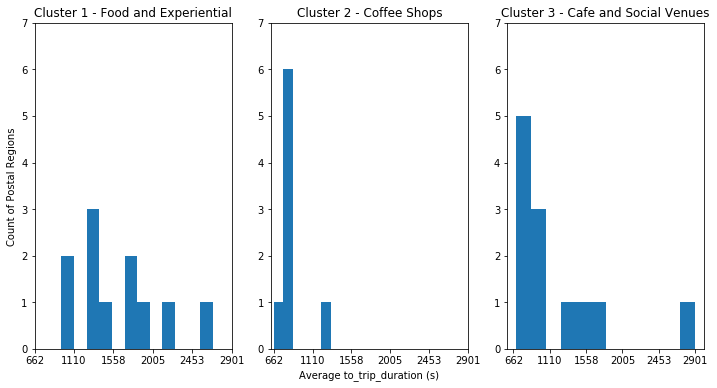

In [80]:
KPI = 'to_trip_duration'# 'station_count' #'bike_visits' #'local_visits' 

import matplotlib as mpl
import matplotlib.pyplot as plt

# CREATING PLOTS SIDE BY SIDE
fig = plt.figure() 
ax1 = fig.add_subplot(1, 3, 1) 
ax2 = fig.add_subplot(1, 3, 2) 
ax3 = fig.add_subplot(1, 3, 3) 

count, bin_edges = np.histogram(Visits_df1[KPI],5)
y_range = np.array([ 0, 1, 2, 3, 4, 5, 6, 7])
spacing = bin_edges[-1]/12

bin_num = int(np.ceil(cluster_summary1[['Cluster 1']].values[-1]/spacing))
cluster1[KPI].plot(kind='hist', figsize=(12, 6), bins=bin_num, xticks=bin_edges, yticks=y_range, ax=ax1)
ax1.set_title('Cluster 1 - Food and Experiential') 
ax1.set_ylabel('Count of Postal Regions')
ax1.set_xlabel('')

bin_num = int(np.ceil(cluster_summary1[['Cluster 2']].values[-1]/spacing))
cluster2[KPI].plot(kind='hist', figsize=(12, 6), bins=bin_num, xticks=bin_edges, yticks=y_range, ax=ax2)
ax2.set_title('Cluster 2 - Coffee Shops') 
ax2.set_ylabel('')
ax2.set_xlabel('Average '+ KPI + ' (s)')

bin_num = int(np.ceil(cluster_summary1[['Cluster 3']].values[-1]/spacing))
cluster3[KPI].plot(kind='hist', figsize=(12, 6), bins=bin_num, xticks=bin_edges, yticks=y_range, ax=ax3)
ax3.set_title('Cluster 3 - Cafe and Social Venues') 
ax3.set_ylabel('')
ax3.set_xlabel('')

plt.show()



3.	Within cluster 3 (Café and Social Venues) rides in the same postal region are double those of other clusters, which suggests that riders are using bike shares to travel to nearby destinations. However, rides to areas outside the cluster area are also high (62K in 2017) which skews the average ride duration a bit longer to 20 mins.  

In [74]:

KPI = 'local_visits'# 'station_count' #'bike_visits' #'local_visits' 
print("Summary Statistics for ",KPI)

cluster1_summary = cluster1.describe()
cluster1_summary = cluster1_summary[[KPI]]
cluster1_summary.rename(columns={KPI:'Cluster 1'}, inplace=True)
cluster2_summary = cluster2.describe()
cluster2_summary = cluster2_summary[[KPI]]
cluster2_summary.rename(columns={KPI:'Cluster 2'}, inplace=True)
cluster3_summary = cluster3.describe()
cluster3_summary = cluster3_summary[[KPI]]
cluster3_summary.rename(columns={KPI:'Cluster 3'}, inplace=True)
cluster_summary = cluster1_summary.join(cluster2_summary)
cluster_summary = cluster_summary.join(cluster3_summary)

cluster_summary['Cluster 1'] = cluster_summary['Cluster 1'].apply(lambda x: round(x))
cluster_summary['Cluster 2'] = cluster_summary['Cluster 2'].apply(lambda x: round(x))
cluster_summary['Cluster 3'] = cluster_summary['Cluster 3'].apply(lambda x: round(x))
cluster_summary1 = cluster_summary
cluster_summary = cluster_summary.astype(str)  

if KPI in ('to_trip_duration', 'from_trip_duration'):
    for i in range(1,cluster_summary.shape[0]):
        sec_to_time(cluster_summary1['Cluster 1'][i])
        cluster_summary['Cluster 1'][i] = time
        sec_to_time(cluster_summary1['Cluster 2'][i])
        cluster_summary['Cluster 2'][i] = time
        sec_to_time(cluster_summary1['Cluster 3'][i])
        cluster_summary['Cluster 3'][i] = time

cluster_summary

Summary Statistics for  local_visits


,Cluster 1,Cluster 2,Cluster 3
count,11,8,12
mean,3095,4478,9941
std,3907,4923,7875
min,90,210,1632
25%,401,676,3564
50%,774,2243,9787
75%,5690,7981,13622
max,11489,13671,28862


#### Discussion

Although Toronto is the biggest city in the Canada, some may consider it underdeveloped compared to other metropolises around the world. When clustering the 31 postal regions, we were able to see some correlation with the urban sprawl. Initially, I hypothesized that types of venues within an area can attract bike share riders, but the research findings showed that subway stations and Union stations attracted the most ridership from nearby areas. 

Additional data from the City of Toronto’s website can be incorporated to account for confounding effects such as total bicycle movements [8] and bikeways (bike lanes, signed bicycle routes, and pathways) [9]. Future studies can include comparing bike share users with everyday bikers or analyzing the correlation with the availability of bike lanes and pathways. Clustering of venues can also include ridership data to consider the traffic in the neighborhood. 

The study was limited to the 31 postal regions as that is where bike share docking stations are. Clustering can expand to include other regions to find similar areas for new stations. Considering that the average duration of a trip is 16 minutes and there is low ridership in cluster 1, new stations should be no further than a 16-minute bike ride away from the nearest existing docking station. 


#### Conclusion

Implications of this study go beyond management of bike share programs to city planning as the flow traffic is dependent on many factors. One approach is to analyze the differences and similarities of neighborhoods to see how communities in Toronto adjust to the increase in traffic or the increase in population. 

As space becomes more limited and growth of transit system is slow, many commuters will consider combinations of transportation based on whichever option is the most efficient. This research proves the case that transportation organizations should work together to find a solution that is different from the traditional way of thinking. One good example is the Presto card system, which made it easier for commuters to transfer in between the GO and the TTC [10].

#### Reference

1.	[Statistics Canada - 2016 Census Results](https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=304&SR=46&S=87&O=A&RPP=5&PR=35&CMA=0&CSD=0)
2.	[Ontario Ministry of Finance - Ontario Population Projection Update](https://www.fin.gov.on.ca/en/economy/demographics/projections/)
3.	[Wikipedia - List of Postal Codes of Canada:M](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
4.	[BeautifulSoup Package](http://beautiful-soup-4.readthedocs.io/en/latest/)
5.	[FourSquare - API](https://developer.foursquare.com/)
6.	[City of Toronto - Bike Share Toronto Ridership Data](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#343faeaa-c920-57d6-6a75-969181b6cbde)
7.	[City of Toronto - Bike Share Toronto](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#84045f23-7465-0892-8889-7b6f91049b29)
8.  [City of Toronto - Bicycle Counts](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#7e3a3b94-92d8-2932-2c59-2c88a6cc0f3f)
9.  [City of Toronto - Bikeeway](https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#62a5e0cf-690e-1a8a-e8c3-81696c6f7cc9) 
10. [PRESTO Card Program](https://www.prestocard.ca/en/)

